In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import seaborn as sns
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler                             
from qiskit_machine_learning.algorithms.classifiers import VQC 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time, copy, warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score


data = pd.read_csv('C:/Users/RDSC/downloads/flc_2013_2022_notime.csv', sep=';')


# Display the first few rows of the dataset to understand its structure
print(data.head())






          open         high          low        close   Volume  Volume MA  \
0  4104.330818  4176.336622  4032.325014  4104.330818  6158668        NaN   
1  4104.330818  4104.330818  3960.319210  4032.325014  4937960        NaN   
2  4032.325014  4104.330818  3960.319210  3960.319210  2287341        NaN   
3  3960.319210  4032.325014  3888.313406  3960.319210  2425496        NaN   
4  3960.319210  3960.319210  3816.307603  3816.307603  3534864        NaN   

   manipulated  
0            0  
1            0  
2            0  
3            0  
4            0  


In [2]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 2: Explore the dimensions
print("Number of rows and columns:", df.shape)

Number of rows and columns: (2170, 7)


In [3]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 1: Handling Missing Values (if any)
# Check for missing values in the DataFrame
print(df.isnull().sum())



open            0
high            0
low             0
close           0
Volume          0
Volume MA      19
manipulated     0
dtype: int64


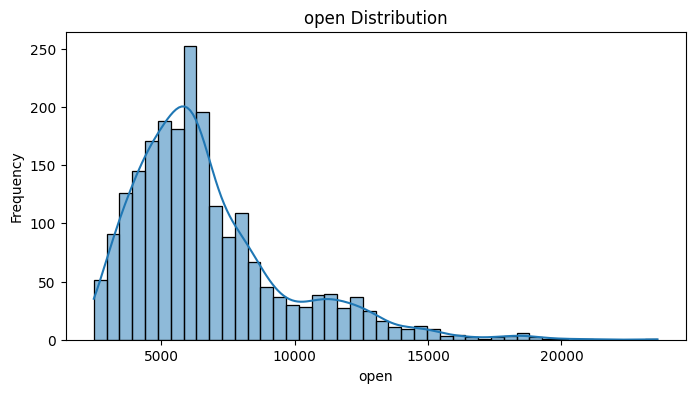

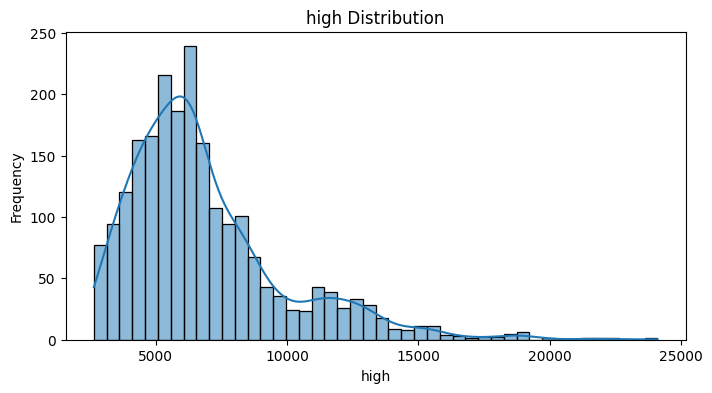

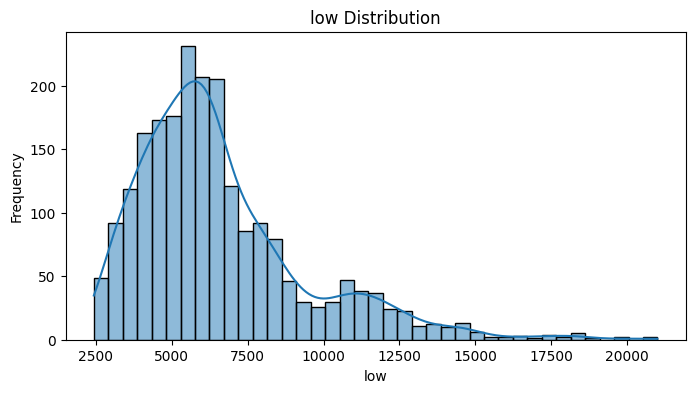

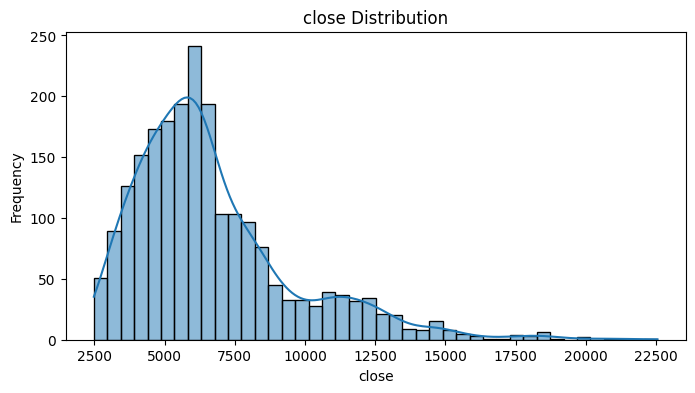

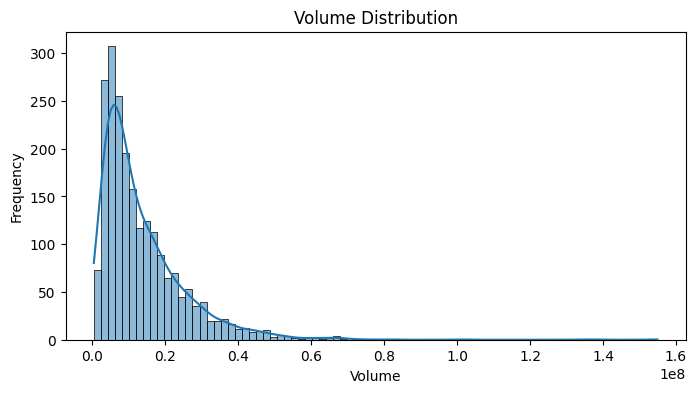

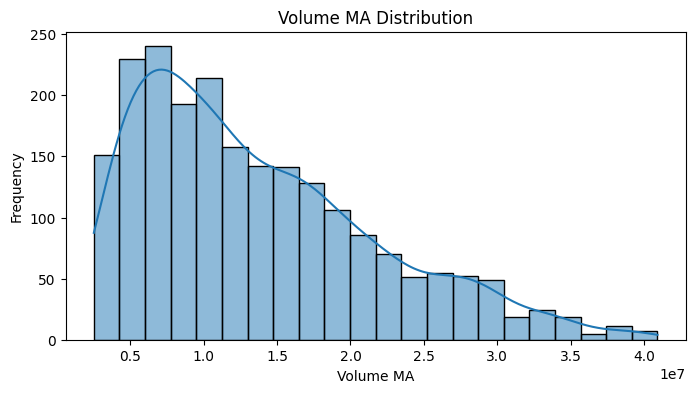

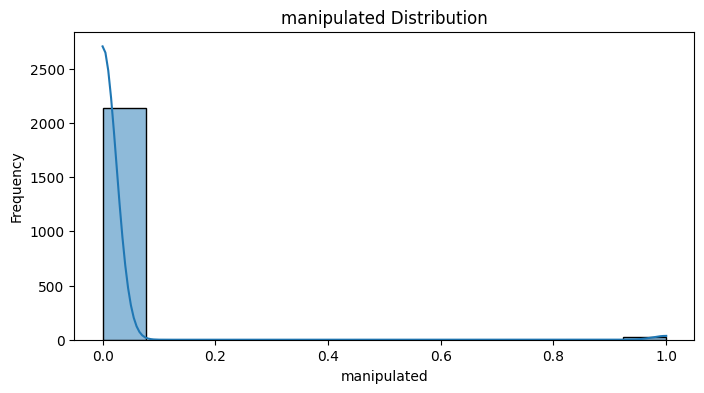

In [4]:
# Step 7: Feature Analysis
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Create histograms for numeric features
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} Distribution")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# Create bar plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, data=df)
    plt.title(f"{feature} Counts")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()



In [5]:
#If there are any missing values, you can impute them with the mean, median, or mode.
# For example, to impute missing values with the mean:
df.fillna(df.mean(), inplace=True)

# Specify the column for which you want to check outliers
column_name = 'manipulated'  

# Calculate the mean and standard deviation of the column
mean = df[column_name].mean()
std = df[column_name].std()

# Define the threshold for identifying outliers (e.g., z-score > 3)
threshold = 3

# Initialize a list to store outliers
outliers = []

# Calculate the z-score for each value in the column and identify outliers
for index, value in df[column_name].iteritems():
    z_score = (value - mean) / std
    if z_score > threshold:
        outliers.append(value)

print('Outliers in the dataset:', outliers)

Outliers in the dataset: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
nonfraud_count = data[data.manipulated == 0]
fraud_count = data[data.manipulated == 1]


num_normal = nonfraud_count.shape[0] 
num_fraud = fraud_count.shape[0] 

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 2142
Number of fraud examples = 28

normal to fraud ratio in the whole data = 76.5


## Undersampling 

In [7]:
# normal_fraud_ratio = 1 means balance sample
normal_fraud_ratio = 1                                     
normal_sample = nonfraud_count.sample(normal_fraud_ratio*num_fraud) 


# The code concatenates the fraud cases from the fraud_count DataFrame and the balanced normal cases from normal_sample to 
# create a new DataFrame called sample. The resulting sample DataFrame now has a balanced class distribution.

sample = pd.concat([fraud_count, normal_sample], axis=0)  

# random shuffling of sample examples 100 times
for i in range(100):
    sample = np.random.permutation(sample)                   


    


In [8]:
sample.shape

(56, 7)

In [9]:
#The variable X contains the feature values from the sample DataFrame, excluding the last column, 
#which contains the class labels (0 or 1).The variable y contains the class labels from the last column of the sample DataFrame.

X, y = sample[:, :-1], sample[:, -1]

# feature scaling
X = MinMaxScaler().fit_transform(X)            

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


X[:,:] , y[:]


number of examples =  56
number of features =  6


(array([[0.7705314 , 0.80660377, 0.87052342, 0.87029502, 0.28988468,
         0.62573999],
        [0.15161636, 0.1480405 , 0.16242833, 0.1484074 , 0.08916375,
         0.36334181],
        [0.42028986, 0.41981132, 0.4738292 , 0.43540183, 0.08488763,
         0.45715141],
        [0.87922705, 0.92688679, 0.99724518, 1.        , 0.22054099,
         0.68184965],
        [0.75362319, 0.76179245, 0.84573003, 0.80417091, 0.12816537,
         0.58499654],
        [0.71980676, 0.73113208, 0.80440771, 0.78382503, 0.14557622,
         0.59331413],
        [0.58937198, 0.58018868, 0.63911846, 0.59562564, 0.15665538,
         0.74917591],
        [0.10301189, 0.1048212 , 0.1152883 , 0.10439892, 0.01823744,
         0.0430479 ],
        [0.74879227, 0.76650943, 0.84848485, 0.81943032, 0.18011698,
         0.58726013],
        [0.1498971 , 0.15314393, 0.1623242 , 0.15239306, 0.12509249,
         0.45673278],
        [0.55072464, 0.56603774, 0.63085399, 0.59562564, 0.09271793,
         0.56722626],

In [10]:
''' 
Zero padding is to make the number of features equal to a power of 2.
it is required for 'amplitude encoding' given below.
'''

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (3, 8)
number of examples =  56
number of features =  8


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape ,  y_train.shape, y_test.shape)

(39, 8) (17, 8) (39,) (17,)


## Model Building

In [12]:
from qiskit_machine_learning.circuit.library import RawFeatureVector


fm = RawFeatureVector(feature_dimension=num_features) 
fm.draw() 

┌───────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                  ├
     │                                                                   │
q_1: ┤1 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) ├
     │                                                                   │
q_2: ┤2                                                                  ├
     └───────────────────────────────────────────────────────────────────┘

In [13]:
from qiskit.circuit.library import RealAmplitudes


'''
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps=6)
pqc.decompose().draw()

┌──────────┐                 ┌──────────┐                 ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────■──────┤ Ry(θ[3]) ├──────────■──────┤ Ry(θ[6]) ├»
     ├──────────┤        ┌─┴─┐    ├──────────┤        ┌─┴─┐    ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──■─────┤ X ├────┤ Ry(θ[4]) ├──■─────┤ X ├────┤ Ry(θ[7]) ├»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘┌─┴─┐┌──┴───┴───┐└──────────┘»
q_2: ┤ Ry(θ[2]) ├┤ X ├┤ Ry(θ[5]) ├────────────┤ X ├┤ Ry(θ[8]) ├────────────»
     └──────────┘└───┘└──────────┘            └───┘└──────────┘            »
«                        ┌──────────┐                  ┌───────────┐     »
«q_0: ───────────■───────┤ Ry(θ[9]) ├───────────■──────┤ Ry(θ[12]) ├─────»
«              ┌─┴─┐    ┌┴──────────┤         ┌─┴─┐    ├───────────┤     »
«q_1: ──■──────┤ X ├────┤ Ry(θ[10]) ├──■──────┤ X ├────┤ Ry(θ[13]) ├──■──»
«     ┌─┴─┐┌───┴───┴───┐└───────────┘┌─┴─┐┌───┴───┴───┐└───────────┘┌─┴─┐»
«q_2: ┤ X ├┤ Ry(θ[11]) ├─────────────┤ X ├┤ Ry(θ[14]) ├─────────────┤ X ├»
«     └───┘└───────────┘             └───┘└───────────┘             └───┘»
«                  ┌───────────┐                  ┌───────────┐
«q_0: ──────■──────┤ Ry(θ[15]) ├───────────■──────┤ Ry(θ[18]) ├
«         ┌─┴─┐    ├───────────┤         ┌─┴─┐    ├───────────┤
«q_1: ────┤ X ├────┤ Ry(θ[16]) ├──■──────┤ X ├────┤ Ry(θ[19]) ├
«     ┌───┴───┴───┐└───────────┘┌─┴─┐┌───┴───┴───┐└───────────┘
«q_2: ┤ Ry(θ[17]) ├─────────────┤ X ├┤ Ry(θ[20]) ├─────────────
«     └───────────┘             └───┘└───────────┘

In [14]:
optimizer = COBYLA(maxiter=150)                 
sampler = Sampler()




objective_func_vals = []
                                    
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## Training and Evaluating performance 

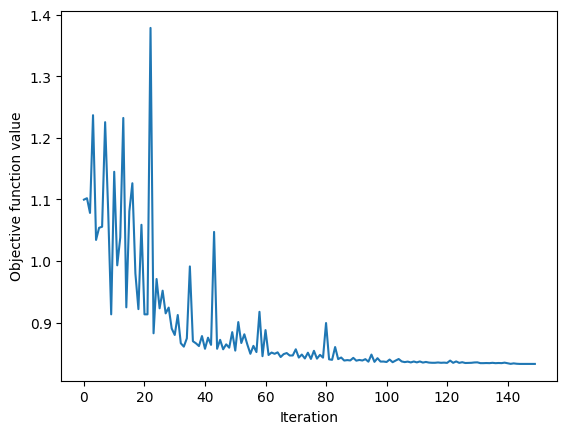

Wall time: 2min 59s


In [15]:
%%time

vqc.fit(X_train, y_train)

In [16]:
y_test_pred = vqc.predict(X_test)


print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")


              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         9
         1.0       0.57      1.00      0.73         8

    accuracy                           0.65        17
   macro avg       0.79      0.67      0.61        17
weighted avg       0.80      0.65      0.61        17

[[3 6]
 [0 8]] = confusion matrix for test set 
 


In [17]:
print(y_test_pred)

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


In [18]:
print(y_test)

[0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
